In [1]:
from scipy.stats import mode
import sqlite3, csv, os
from sqlalchemy import (Boolean, Column, Enum, ForeignKey, Integer, String,PickleType,MetaData,
                        Float,Table, UniqueConstraint, create_engine)
from sqlalchemy import (not_, select,and_) 
from datetime import datetime
from sqlalchemy import *
from sqlalchemy.dialects.postgresql import ARRAY
from sklearn import datasets
from sklearn import *
# from sklearn.model_selection import train_test_split
from numpy import genfromtxt
import numpy as np
import time
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
# from sklearn import model_selection
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# from unsupervised_alt import *
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

/home/lun5/anaconda2/envs/biomarkers/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lun5/anaconda2/envs/biomarkers/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/lun5/anaconda2/envs/biomarkers/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and w

In [2]:
# set up all dictionaries to store the results
fpr_dict = dict()
tpr_dict = dict()
auc_dict = dict()
acc_dict = dict()

# Binary classification

### Beck's

In [5]:
# load dataset
data_path = '/media/SpatialPathology'
data_fname = 'ComputedFeatures_Label.csv'
data = []
Class = []
CaseName = []
ClassGrade = []

with open(os.path.join(data_path,data_fname),'rb') as csvfile:
    f_csv = csv.reader(csvfile,delimiter=',')
    f_csv = csv.DictReader(csvfile)
    for row in f_csv:
        data.append([float(value) for key, value in row.items() if key not in [
                   'Class','ClassGrade','CaseName','ER']])
        Class.append(row['Class'])
        ClassGrade.append(row['ClassGrade'])
        CaseName.append(row['CaseName'])

data = np.vstack(data)
print data.shape
ClassLabel = np.asarray([int(Class[i]=='DCIS') 
                         for i in xrange(len(Class))])
# print ClassLabel
data_train = data[:116,:]
data_test = data[116:,:]
y_train = ClassLabel[:116]
y_test = ClassLabel[116:]

print data_train.shape, data_test.shape, y_train.shape, y_test.shape

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
               'red','turquoise','lightgreen'])
lw = 2
cv = StratifiedKFold(n_splits=9)

# scaler = preprocessing.StandardScaler().fit(data_train)
# data_train_scaled = scaler.transform(data_train)
# scaler = preprocessing.StandardScaler().fit(data_test)
# data_test_scaled = scaler.transform(data_test)

scaler = preprocessing.StandardScaler().fit(data)
X = scaler.transform(data)
y = ClassLabel

random_state = np.random.RandomState(1234)
# , scoring='roc_auc'
cv_model = linear_model.LogisticRegressionCV(Cs = 100,cv = cv, 
            penalty='l1',solver='liblinear', refit = True,scoring = 'roc_auc',
            random_state = random_state)
cv_model.fit(X,y)
# print cv_model.C_
C = cv_model.C_[0]
print 'Regularization parameter: ', C
print 'Num of features: ', np.sum(cv_model.coef_ != 0)
for key in cv_model.scores_:
    print key, cv_model.scores_[key].shape
# clf = linear_model.LogisticRegression(
#     penalty='l1',C = C, random_state=random_state)
# clf.fit(X,y)

# probas_ = clf.predict_proba(data_test_scaled)
probas_ = cv_model.predict_proba(X)
fpr, tpr, _ = roc_curve(y, probas_[:,1])
roc_auc = auc(fpr, tpr)
# ypred = clf.predict(data_test_scaled)
# ypred = cv_model.predict(data_test_scaled)
# acc = accuracy_score(y_test, ypred)
acc = cv_model.score(data,y)

# print 'Accuracy is %0.2f' %(acc)

setting = 'nucFeats'
print('Setting %s has C=%0.2f and %d non zero coefficients' %(
        setting, C,np.sum(cv_model.coef_ !=0 ) ))
print('all CV: AUC = %0.2f, acc = %0.2f' %(
            roc_auc,acc))
    
curr_key = (setting + '_CV' + '_bin' )
fpr_dict[curr_key] = fpr
tpr_dict[curr_key] = tpr
auc_dict[curr_key] = roc_auc
acc_dict[curr_key] = acc
    
# plt.plot(fpr, tpr, lw=lw, color=color,
#              label='AUC = %0.2f' % (roc_auc))

# plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
#          label='Luck')

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

(167, 392)
(116, 392) (51, 392) (116,) (51,)
Regularization parameter:  0.35938136638
Num of features:  25
1 (9, 100)
Setting nucFeats has C=0.36 and 25 non zero coefficients
all CV: AUC = 0.98, acc = 0.40


In [14]:
# load dataset
data_path = '/media/SpatialPathology'
data_fname = 'ComputedFeatures_Label.csv'
data = []
Class = []
CaseName = []
ClassGrade = []

with open(os.path.join(data_path,data_fname),'rb') as csvfile:
    f_csv = csv.reader(csvfile,delimiter=',')
    f_csv = csv.DictReader(csvfile)
    for row in f_csv:
        data.append([float(value) for key, value in row.items() if key not in [
                   'Class','ClassGrade','CaseName','ER']])
        Class.append(row['Class'])
        ClassGrade.append(row['ClassGrade'])
        CaseName.append(row['CaseName'])

data = np.vstack(data)
print data.shape
ClassLabel = np.asarray([int(Class[i]=='DCIS') 
                         for i in xrange(len(Class))])
# print ClassLabel
data_train = data[:116,:]
data_test = data[116:,:]
y_train = ClassLabel[:116]
y_test = ClassLabel[116:]

print data_train.shape, data_test.shape, y_train.shape, y_test.shape

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
               'red','turquoise','lightgreen'])
lw = 2
cv = StratifiedKFold(n_splits=9)

scaler = preprocessing.StandardScaler().fit(data_train)
data_train_scaled = scaler.transform(data_train)
# scaler = preprocessing.StandardScaler().fit(data_test)
data_test_scaled = scaler.transform(data_test)

random_state = np.random.RandomState(1234)
# , scoring='roc_auc'
cv_model = linear_model.LogisticRegressionCV(Cs = 50,cv = 9, 
            penalty='l1',solver='liblinear', scoring = 'roc_auc',
            random_state = random_state)
cv_model.fit(data_train_scaled,y_train)
# print cv_model.C_
C = cv_model.C_[0]
# print 'Regularization parameter: ', C
# print 'Num of features: ', np.sum(cv_model.coef_ != 0)
# for key in cv_model.scores_:
#     print key, cv_model.scores_[key].shape
# clf = linear_model.LogisticRegression(
#     penalty='l1',C = C, random_state=random_state)
# clf.fit(X,y)

############################################################
########################TRAIN###############################
############################################################
probas_ = cv_model.predict_proba(data_train_scaled)
fpr, tpr, _ = roc_curve(y_train, probas_[:,1])
roc_auc = auc(fpr, tpr)
# ypred = clf.predict(data_test_scaled)
# ypred = cv_model.predict(data_test_scaled)
# acc = accuracy_score(y_test, ypred)
acc = cv_model.score(data_train_scaled,y_train)

setting = 'nucFeats'
print('Setting %s has C=%0.2f and %d non zero coefficients' %(
        setting, C,np.sum(cv_model.coef_ !=0 ) ))
print('Train: AUC = %0.2f, acc = %0.2f' %(
            roc_auc,acc))
    
curr_key = (setting + '_val' + '_bin' )
fpr_dict[curr_key] = fpr
tpr_dict[curr_key] = tpr
auc_dict[curr_key] = roc_auc
acc_dict[curr_key] = acc

############################################################
#########################TEST###############################
############################################################
# probas_ = clf.predict_proba(data_test_scaled)
probas_ = cv_model.predict_proba(data_test_scaled)
fpr, tpr, _ = roc_curve(y_test, probas_[:,1])
roc_auc = auc(fpr, tpr)
# ypred = clf.predict(data_test_scaled)
# ypred = cv_model.predict(data_test_scaled)
# acc = accuracy_score(y_test, ypred)
acc = cv_model.score(data_test_scaled,y_test)

curr_key = (setting + '_test' + '_bin' )
fpr_dict[curr_key] = fpr
tpr_dict[curr_key] = tpr
auc_dict[curr_key] = roc_auc
acc_dict[curr_key] = acc

print('Test: AUC = %0.2f, acc = %0.2f' %(
            roc_auc,acc))
# print 'Accuracy is %0.2f' %(acc)
# plt.plot(fpr, tpr, lw=lw, color=color,
#              label='AUC = %0.2f' % (roc_auc))

# plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
#          label='Luck')

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

(167, 392)
(116, 392) (51, 392) (116,) (51,)
Setting nucFeats has C=5.43 and 42 non zero coefficients
Train: AUC = 1.00, acc = 1.00
Test: AUC = 0.58, acc = 0.59


### Random walk features

In [10]:
rw_settings = ['colorobjectclusters',
               'cellclusters_maxD5_k90',
               'cellclusters_maxD5_k90_SI',
               'cellclusters_maxD5_k95',
               'cellclusters_maxD5_k95_SI',
               'cellclusters_maxD10_k90',
               'cellclusters_maxD10_k90_SI',
               'cellclusters_maxD10_k95',
               'cellclusters_maxD10_k95_SI',
               'combinedcellclusters_maxD5_k90',
              'combinedcellclusters_maxD5_k90_SI',
              'combinedcellclusters_maxD5_k95',
              'combinedcellclusters_maxD5_k95_SI',
               'combinedcellclusters_maxD10_k90',
              'combinedcellclusters_maxD10_k90_SI',
              'combinedcellclusters_maxD10_k95',
              'combinedcellclusters_maxD10_k95_SI'
              ]
rw_dir = '/media/SpatialPathology/random_walk_features/'

In [11]:
for param_set in xrange(len(rw_settings)):
    #print('parameter setting %s' %(rw_settings[param_set]))
    # read in the file
    CaseName = []
    ClassGrade = []
    Hospital = []
    rw_data = []
    with open(os.path.join(rw_dir, (
                'train_test_list_' + rw_settings[param_set]+'.csv')),'rb') as csvfile:
        f_csv = csv.reader(csvfile,delimiter = ',')
        for row in f_csv:
            CaseName.append(row[0])
            ClassGrade.append(int(row[1]))
            Hospital.append(int(row[2]))
            rw_data.append([float(row[i]) for i in xrange(3,len(row))])
    data = np.vstack(rw_data)
    ClassGrade = np.asarray(ClassGrade)
    ClassLabel = np.asarray([int(ClassGrade[i] > 0) for i in 
                                 xrange(len(ClassGrade))])
    Hospital = np.asarray(Hospital)
    #print rw_data.shape, ClassGrade.shape
    data_train = data[Hospital == 1,:]
    data_test = data[Hospital == 0, :]
    y_train = ClassLabel[Hospital == 1]
    y_test = ClassLabel[Hospital == 0]
    #print data_train.shape, data_test.shape, len(y_train), len(y_test)
    ###################################################
    ###################BINARY###################
    ###################################################
    scaler = preprocessing.StandardScaler().fit(data)
    X = scaler.transform(data)
    y = ClassLabel
    random_state = np.random.RandomState(123)
    #C = 5
    
    cv_model = linear_model.LogisticRegressionCV(
        Cs = 50, cv = 9, penalty='l1', 
        scoring='roc_auc',solver='liblinear')
    cv_model.fit(X,y)
    C = cv_model.C_[0]
    #####################################################
    ######################FOR CV######################
    #####################################################
    #print model.Cs_    
    probas_ = cv_model.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, probas_[:,1])
    roc_auc = auc(fpr, tpr)
    acc = cv_model.score(X,y)
    
    setting = rw_settings[param_set]
    print('Setting %s has C=%0.2f and %d non zero coefficients' %(
        setting, C,np.sum(cv_model.coef_ !=0 ) ))
    print('all CV: AUC = %0.2f, acc = %0.2f' %(
            roc_auc,acc))
    
    curr_key = (setting + '_CV' + '_bin' )
    fpr_dict[curr_key] = fpr
    tpr_dict[curr_key] = tpr
    auc_dict[curr_key] = roc_auc
    acc_dict[curr_key] = acc

Setting colorobjectclusters has C=0.39 and 3 non zero coefficients
all CV: AUC = 0.84, acc = 0.78
Setting cellclusters_maxD5_k90 has C=0.09 and 3 non zero coefficients
all CV: AUC = 0.74, acc = 0.68
Setting cellclusters_maxD5_k90_SI has C=11.51 and 6 non zero coefficients
all CV: AUC = 0.71, acc = 0.68
Setting cellclusters_maxD5_k95 has C=0.03 and 1 non zero coefficients
all CV: AUC = 0.72, acc = 0.68
Setting cellclusters_maxD5_k95_SI has C=0.13 and 5 non zero coefficients
all CV: AUC = 0.69, acc = 0.66
Setting cellclusters_maxD10_k90 has C=0.03 and 1 non zero coefficients
all CV: AUC = 0.76, acc = 0.70
Setting cellclusters_maxD10_k90_SI has C=1.76 and 9 non zero coefficients
all CV: AUC = 0.73, acc = 0.67
Setting cellclusters_maxD10_k95 has C=0.18 and 8 non zero coefficients
all CV: AUC = 0.79, acc = 0.72
Setting cellclusters_maxD10_k95_SI has C=0.39 and 11 non zero coefficients
all CV: AUC = 0.75, acc = 0.70
Setting combinedcellclusters_maxD5_k90 has C=0.06 and 1 non zero coefficient

In [12]:
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
               'red','turquoise','lightgreen'])
lw = 2
cv = StratifiedKFold(n_splits=9)

# CaseName = []
# ClassGrade = []
# Hospital = []
# rw_data = []
for param_set in xrange(len(rw_settings)):
    #print('parameter setting %s' %(rw_settings[param_set]))
    # read in the file
    CaseName = []
    ClassGrade = []
    Hospital = []
    rw_data = []
    with open(os.path.join(rw_dir, (
                'train_test_list_' + rw_settings[param_set]+'.csv')),'rb') as csvfile:
        f_csv = csv.reader(csvfile,delimiter = ',')
        for row in f_csv:
            CaseName.append(row[0])
            ClassGrade.append(int(row[1]))
            Hospital.append(int(row[2]))
            rw_data.append([float(row[i]) for i in xrange(3,len(row))])
    data = np.vstack(rw_data)
    ClassGrade = np.asarray(ClassGrade)
    ClassLabel = np.asarray([int(ClassGrade[i] > 0) for i in 
                                 xrange(len(ClassGrade))])
    Hospital = np.asarray(Hospital)
    #print rw_data.shape, ClassGrade.shape
    data_train = data[Hospital == 1,:]
    data_test = data[Hospital == 0, :]
    y_train = ClassLabel[Hospital == 1]
    y_test = ClassLabel[Hospital == 0]
    #print data_train.shape, data_test.shape, len(y_train), len(y_test)
    ###################################################
    ###################BINARY###################
    ###################################################
    scaler = preprocessing.StandardScaler().fit(data_train)
    data_train_scaled = scaler.transform(data_train)
    data_test_scaled = scaler.transform(data_test)
    
    random_state = np.random.RandomState(123)
    #C = 5
    
    cv_model = linear_model.LogisticRegressionCV(
        Cs = 50, cv = 9, penalty='l1', 
        scoring='roc_auc',solver='liblinear')
    cv_model.fit(data_train_scaled,y_train)
    C = cv_model.C_[0]
    #####################################################
    ######################FOR TRAIN######################
    #####################################################
    #print model.Cs_    
    probas_ = cv_model.predict_proba(data_train_scaled)
    fpr, tpr, _ = roc_curve(y_train, probas_[:,1])
    roc_auc = auc(fpr, tpr)
    
    #val_auc = np.max(np.mean(cv_model.scores_[1],axis=0))
    #print val_auc
    # ypred = clf.predict(data_test_scaled)
    #ypred = cv_model.predict(data_test_scaled)
    #acc = accuracy_score(y_test, ypred)
    acc = cv_model.score(data_train_scaled, y_train)
    setting = rw_settings[param_set]
    print('Setting %s has C=%0.2f and %d non zero coefficients' %(
        setting, C,np.sum(cv_model.coef_ !=0 ) ))
    print('Train: AUC = %0.2f, acc = %0.2f' %(
            roc_auc,acc))
    
    curr_key = (setting + '_val' + '_bin' )
    fpr_dict[curr_key] = fpr
    tpr_dict[curr_key] = tpr
    auc_dict[curr_key] = roc_auc
    acc_dict[curr_key] = acc
    #####################################################
    ######################FOR TEST######################
    #####################################################
    probas_ = cv_model.predict_proba(data_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, probas_[:,1])
    roc_auc = auc(fpr, tpr)
    acc = cv_model.score(data_test_scaled, y_test)
    print('Test: AUC = %0.2f, acc = %0.2f' %(
            roc_auc,acc))
    
    curr_key = (setting + '_test' + '_bin' )
    fpr_dict[curr_key] = fpr
    tpr_dict[curr_key] = tpr
    auc_dict[curr_key] = roc_auc
    acc_dict[curr_key] = acc

Setting colorobjectclusters has C=0.27 and 3 non zero coefficients
Train: AUC = 0.87, acc = 0.79
Test: AUC = 0.68, acc = 0.53
Setting cellclusters_maxD5_k90 has C=0.06 and 3 non zero coefficients
Train: AUC = 0.73, acc = 0.72
Test: AUC = 0.63, acc = 0.37
Setting cellclusters_maxD5_k90_SI has C=0.06 and 1 non zero coefficients
Train: AUC = 0.68, acc = 0.71
Test: AUC = 0.64, acc = 0.39
Setting cellclusters_maxD5_k95 has C=0.13 and 4 non zero coefficients
Train: AUC = 0.73, acc = 0.71
Test: AUC = 0.64, acc = 0.43
Setting cellclusters_maxD5_k95_SI has C=0.39 and 7 non zero coefficients
Train: AUC = 0.70, acc = 0.71
Test: AUC = 0.58, acc = 0.39
Setting cellclusters_maxD10_k90 has C=0.13 and 3 non zero coefficients
Train: AUC = 0.75, acc = 0.72
Test: AUC = 0.70, acc = 0.53
Setting cellclusters_maxD10_k90_SI has C=0.06 and 2 non zero coefficients
Train: AUC = 0.70, acc = 0.71
Test: AUC = 0.58, acc = 0.39
Setting cellclusters_maxD10_k95 has C=0.83 and 10 non zero coefficients
Train: AUC = 0.77

# 4 way

### Beck's

In [17]:
# load dataset
data_path = '/media/SpatialPathology'
data_fname = 'ComputedFeatures_Label.csv'
data = []
Class = []
CaseName = []
ClassGrade = []

with open(os.path.join(data_path,data_fname),'rb') as csvfile:
    f_csv = csv.reader(csvfile,delimiter=',')
    f_csv = csv.DictReader(csvfile)
    for row in f_csv:
        data.append([float(value) for key, value in row.items() if key not in [
                   'Class','ClassGrade','CaseName','ER']])
        Class.append(row['Class'])
        ClassGrade.append(row['ClassGrade'])
        CaseName.append(row['CaseName'])

data = np.vstack(data)
print data.shape
ClassLabel = np.asarray([int(Class[i]=='DCIS') for i in xrange(len(Class))])
# print ClassLabel
data_train = data[:116,:]
data_test = data[116:,:]
ClassGradeBin = preprocessing.label_binarize(ClassGrade,classes=[
        'UDH','Low_DCIS','Medium_DCIS','High_DCIS'])
ClassGradeLabel = np.argmax(ClassGradeBin,axis = 1)
n_classes = ClassGradeBin.shape[1]

y_train = ClassGradeLabel[:116]
y_test = ClassGradeLabel[116:]

print data_train.shape, data_test.shape, y_train.shape, y_test.shape

scaler = preprocessing.StandardScaler().fit(data)
data_scaled = scaler.transform(data)

X = data_scaled
y = np.asarray(ClassGradeLabel)
y_bin = ClassGradeBin

random_state = np.random.RandomState(123)
#C = 1
cv_model = linear_model.LogisticRegressionCV(Cs = 50,cv = 9, 
        penalty='l1', scoring='roc_auc',solver='liblinear')
cv_model.fit(X,y)
#print np.mean(cv_model.C_)
#print mode(cv_model.C_)
C = mode(cv_model.C_)[0][0]
probas_ = cv_model.predict_proba(X)

# Compute ROC curve and area the curve
fpr = dict()
tpr = dict()
roc_auc = dict()
    
for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_bin[:,j], probas_[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probas_.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# macro average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for j in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[j], tpr[j])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

acc = cv_model.score(X,y)
ypred = cv_model.predict(X)
# print ypred
setting = 'nucFeats'
print('Setting is %s has C=%0.2f, numFeats = %d' %(setting, C, np.sum(cv_model.coef_ !=0)))
print('Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f' %(
    acc, roc_auc['micro'], roc_auc['macro']))

curr_key = (setting + '_micro' + '_CV' + '_4way' )
fpr_dict[curr_key] = fpr['micro']
tpr_dict[curr_key] = tpr['micro']
auc_dict[curr_key] = roc_auc['micro']

curr_key = (setting + '_macro' + '_CV' + '_4way' )
fpr_dict[curr_key] = fpr['macro']
tpr_dict[curr_key] = tpr['macro']
auc_dict[curr_key] = roc_auc['macro']

curr_key = (setting + '_CV' + '_4way' )
acc_dict[curr_key] = acc

(167, 392)
(116, 392) (51, 392) (116,) (51,)
Setting is nucFeats has C=0.06, numFeats = 85
Acc=0.80, micro auc =0.96, macro auc = 0.95


In [37]:
# load dataset
from sklearn.metrics import roc_auc_score
data_path = '/media/SpatialPathology'
data_fname = 'ComputedFeatures_Label.csv'
data = []
Class = []
CaseName = []
ClassGrade = []

with open(os.path.join(data_path,data_fname),'rb') as csvfile:
    f_csv = csv.reader(csvfile,delimiter=',')
    f_csv = csv.DictReader(csvfile)
    for row in f_csv:
        data.append([float(value) for key, value in row.items() if key not in [
                   'Class','ClassGrade','CaseName','ER']])
        Class.append(row['Class'])
        ClassGrade.append(row['ClassGrade'])
        CaseName.append(row['CaseName'])

data = np.vstack(data)
print data.shape
ClassLabel = np.asarray([int(Class[i]=='DCIS') for i in xrange(len(Class))])
# print ClassLabel
data_train = data[:116,:]
data_test = data[116:,:]
ClassGradeBin = preprocessing.label_binarize(ClassGrade,classes=[
        'UDH','Low_DCIS','Medium_DCIS','High_DCIS'])
ClassGradeLabel = np.argmax(ClassGradeBin,axis = 1)
n_classes = ClassGradeBin.shape[1]

y_train = ClassGradeLabel[:116]
y_test = ClassGradeLabel[116:]

print data_train.shape, data_test.shape, y_train.shape, y_test.shape

scaler = preprocessing.StandardScaler().fit(data)
data_scaled = scaler.transform(data)

scaler = preprocessing.StandardScaler().fit(data_train)
data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test)
X = data_train_scaled
y = np.asarray(y_train)
y_bin = ClassGradeBin
y_train_bin = ClassGradeBin[:116,:]
y_test_bin = ClassGradeBin[116:,:]

random_state = np.random.RandomState(123)
#C = 1
cv_model = linear_model.LogisticRegressionCV(Cs = 100,cv = 9, 
        penalty='l1', scoring='roc_auc',solver='liblinear')
cv_model.fit(data_train_scaled,y_train)
#print np.mean(cv_model.C_)
#print mode(cv_model.C_)
C = mode(cv_model.C_)[0][0]

#########################################################
################ Here is for the training set############
########################################################

probas_ = cv_model.predict_proba(data_train_scaled)
# Compute ROC curve and area the curve
fpr = dict()
tpr = dict()
roc_auc = dict()
    
for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_train_bin[:,j], probas_[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_bin.ravel(),
                                          probas_.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# macro average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for j in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[j], tpr[j])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

acc = cv_model.score(X,y)
ypred = cv_model.predict(X)
print ypred
setting = 'nucFeats'
print('Setting is %s has C=%0.2f numFeats = %d' %(setting, C, np.sum(cv_model.coef_!=0)))
print('Train: Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f' %(
    acc, roc_auc['micro'], roc_auc['macro']))

curr_key = (setting + '_micro' + '_val' + '_4way' )
fpr_dict[curr_key] = fpr['micro']
tpr_dict[curr_key] = tpr['micro']
auc_dict[curr_key] = roc_auc['micro']

curr_key = (setting + '_macro' + '_val' + '_4way' )
fpr_dict[curr_key] = fpr['macro']
tpr_dict[curr_key] = tpr['macro']
auc_dict[curr_key] = roc_auc['macro']

curr_key = (setting + '_val' + '_4way' )
acc_dict[curr_key] = acc

#########################################################
################ Here is for the test set############
########################################################

probas_ = cv_model.predict_proba(data_test_scaled)
# Compute ROC curve and area the curve
fpr = dict()
tpr = dict()
roc_auc = dict()
    
for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:,j], probas_[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(),
                                          probas_.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc['micro'] = roc_auc_score(y_test_bin, probas_, average = 'micro')
    
# macro average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for j in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[j], tpr[j])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
roc_auc['macro'] = roc_auc_score(y_test_bin, probas_, average = 'macro')
acc = cv_model.score(data_test_scaled,y_test)
# ypred = cv_model.predict(data_test_scaled)
# print ypred
#setting = 'nucFeats'
#print('Setting is %s has C=%0.2f' %(setting, C))
print('Test: Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f' %(
    acc, roc_auc['micro'], roc_auc['macro']))

curr_key = (setting + '_micro' + '_test' + '_4way' )
fpr_dict[curr_key] = fpr['micro']
tpr_dict[curr_key] = tpr['micro']
auc_dict[curr_key] = roc_auc['micro']

curr_key = (setting + '_macro' + '_test' + '_4way' )
fpr_dict[curr_key] = fpr['macro']
tpr_dict[curr_key] = tpr['macro']
auc_dict[curr_key] = roc_auc['macro']

curr_key = (setting + '_test' + '_4way' )
acc_dict[curr_key] = acc

(167, 392)
(116, 392) (51, 392) (116,) (51,)
[0 0 0 3 1 1 1 1 1 1 1 3 1 1 1 1 1 1 0 0 3 0 3 0 0 0 0 3 3 3 2 2 2 3 3 2 3
 3 2 2 2 2 2 2 2 2 2 2 3 1 3 3 3 3 3 3 1 2 3 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 0 0 0]
Setting is nucFeats has C=0.25 numFeats = 277
Train: Acc=0.97, micro auc =1.00, macro auc = 1.00
Test: Acc=0.59, micro auc =0.70, macro auc = 0.69


### Random walk features

In [21]:
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
               'red','turquoise','lightgreen'])
lw = 2
cv = StratifiedKFold(n_splits=9)

# CaseName = []
# ClassGrade = []
# Hospital = []
# rw_data = []
for param_set in xrange(len(rw_settings)):
    print('parameter setting %s' %(rw_settings[param_set]))
    # read in the file
    CaseName = []
    ClassGrade = []
    Hospital = []
    rw_data = []
    with open(os.path.join(rw_dir, (
                'train_test_list_' + rw_settings[param_set]+'.csv')),'rb') as csvfile:
        f_csv = csv.reader(csvfile,delimiter = ',')
        for row in f_csv:
            CaseName.append(row[0])
            ClassGrade.append(int(row[1]))
            Hospital.append(int(row[2]))
            rw_data.append([float(row[i]) for i in xrange(3,len(row))])
    data = np.vstack(rw_data)
    ClassGrade = np.asarray(ClassGrade)
    ClassGradeBin = preprocessing.label_binarize(ClassGrade, classes =[0,1,2,3])
    ClassLabel = np.asarray([int(ClassGrade[i] > 0) for i in 
                                 xrange(len(ClassGrade))])
    Hospital = np.asarray(Hospital)
    #print rw_data.shape, ClassGrade.shape
    data_train = data[Hospital == 1,:]
    data_test = data[Hospital == 0, :]
    y_train = ClassLabel[Hospital == 1]
    y_test = ClassLabel[Hospital == 0]
    #print data_train.shape, data_test.shape, len(y_train), len(y_test)

    ###################################################
    ###################BINARY###################
    ###################################################
    scaler = preprocessing.StandardScaler().fit(data)
    X = scaler.transform(data)
    y = ClassGrade
    y_bin = ClassGradeBin

    random_state = np.random.RandomState(123)
    ##############################################
    ###################CV for C###################
    ##############################################
    cv_model = linear_model.LogisticRegressionCV(
        Cs=50,cv = 9, penalty='l1', scoring='roc_auc',solver='liblinear')
    cv_model.fit(X,y)
    #print np.mean(cv_model.C_)
    C = mode(cv_model.C_)[0][0]
    #C = 1
    probas_ = cv_model.predict_proba(X)

    # Compute ROC curve and area the curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_bin[:,j], probas_[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probas_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # macro average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[j], tpr[j])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    acc = cv_model.score(X,y)
    ypred = cv_model.predict(X)#   print 'prediction is', ypred
    setting = rw_settings[param_set]
    print('Setting is %s has C=%0.2f and %d non zero coeffs' %(
            setting, C, np.sum(cv_model.coef_ !=0)))
    print('Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f' %(
        acc, roc_auc['micro'], roc_auc['macro']))

    curr_key = (setting + '_micro' + '_CV' + '_4way' )
    fpr_dict[curr_key] = fpr['micro']
    tpr_dict[curr_key] = tpr['micro']
    auc_dict[curr_key] = roc_auc['micro']

    curr_key = (setting + '_macro' + '_CV' + '_4way' )
    fpr_dict[curr_key] = fpr['macro']
    tpr_dict[curr_key] = tpr['macro']
    auc_dict[curr_key] = roc_auc['macro']

    curr_key = (setting + '_CV' + '_4way' )
    acc_dict[curr_key] = acc

parameter setting colorobjectclusters
Setting is colorobjectclusters has C=0.04 and 14 non zero coeffs
Acc=0.48, micro auc =0.76, macro auc = 0.75
parameter setting cellclusters_maxD5_k90
Setting is cellclusters_maxD5_k90 has C=0.06 and 13 non zero coeffs
Acc=0.47, micro auc =0.75, macro auc = 0.75
parameter setting cellclusters_maxD5_k90_SI
Setting is cellclusters_maxD5_k90_SI has C=0.06 and 16 non zero coeffs
Acc=0.45, micro auc =0.71, macro auc = 0.67
parameter setting cellclusters_maxD5_k95
Setting is cellclusters_maxD5_k95 has C=0.06 and 16 non zero coeffs
Acc=0.49, micro auc =0.75, macro auc = 0.73
parameter setting cellclusters_maxD5_k95_SI
Setting is cellclusters_maxD5_k95_SI has C=0.03 and 19 non zero coeffs
Acc=0.38, micro auc =0.68, macro auc = 0.69
parameter setting cellclusters_maxD10_k90
Setting is cellclusters_maxD10_k90 has C=0.03 and 34 non zero coeffs
Acc=0.50, micro auc =0.79, macro auc = 0.79
parameter setting cellclusters_maxD10_k90_SI
Setting is cellclusters_maxD1

In [39]:
rw_settings[7]

'cellclusters_maxD10_k95'

In [40]:
for param_set in [7]:
    print('parameter setting %s' %(rw_settings[param_set]))
    # read in the file
    CaseName = []
    ClassGrade = []
    Hospital = []
    rw_data = []
    with open(os.path.join(rw_dir, (
                'train_test_list_' + rw_settings[param_set]+'.csv')),'rb') as csvfile:
        f_csv = csv.reader(csvfile,delimiter = ',')
        for row in f_csv:
            CaseName.append(row[0])
            ClassGrade.append(int(row[1]))
            Hospital.append(int(row[2]))
            rw_data.append([float(row[i]) for i in xrange(3,len(row))])
    data = np.vstack(rw_data)
    ClassGrade = np.asarray(ClassGrade)
    ClassGradeBin = preprocessing.label_binarize(ClassGrade, classes =[0,1,2,3])
    ClassLabel = np.asarray([int(ClassGrade[i] > 0) for i in 
                                 xrange(len(ClassGrade))])
    Hospital = np.asarray(Hospital)
    #print rw_data.shape, ClassGrade.shape
    data_train = data[Hospital == 1,:]
    data_test = data[Hospital == 0, :]
    y_train = ClassGrade[Hospital == 1]
    y_test = ClassGrade[Hospital == 0]
    #print data_train.shape, data_test.shape, len(y_train), len(y_test)

    ###################################################
    ###################BINARY###################
    ###################################################
    scaler = preprocessing.StandardScaler().fit(data_train)
    data_train_scaled = scaler.transform(data_train)
    data_test_scaled = scaler.transform(data_test)
    y_bin = ClassGradeBin
    y_train_bin = ClassGradeBin[Hospital == 1,:]
    y_test_bin = ClassGradeBin[Hospital == 0,:]

    random_state = np.random.RandomState(123)
    ##############################################
    ###################CV for train ###################
    ##############################################
    cv_model = linear_model.LogisticRegressionCV(
        Cs=50,cv = 9, penalty='l1', scoring='roc_auc',solver='liblinear')
    cv_model.fit(data_train_scaled,y_train)
    #print np.mean(cv_model.C_)
    C = mode(cv_model.C_)[0][0]
    #C = 1
    probas_ = cv_model.predict_proba(data_train_scaled)

    # Compute ROC curve and area the curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_train_bin[:,j], probas_[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_train_bin.ravel(), probas_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # macro average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[j], tpr[j])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    acc = cv_model.score(data_train_scaled,y_train)
    ypred = cv_model.predict(data_train_scaled)#   print 'prediction is', ypred
    setting = rw_settings[param_set]
    print('Setting is %s has C=%0.2f and %d non zero coeffs' %(
            setting, C, np.sum(cv_model.coef_ !=0)))
    print('Train: Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f' %(
        acc, roc_auc['micro'], roc_auc['macro']))

    curr_key = (setting + '_micro' + '_val' + '_4way' )
    fpr_dict[curr_key] = fpr['micro']
    tpr_dict[curr_key] = tpr['micro']
    auc_dict[curr_key] = roc_auc['micro']

    curr_key = (setting + '_macro' + '_val' + '_4way' )
    fpr_dict[curr_key] = fpr['macro']
    tpr_dict[curr_key] = tpr['macro']
    auc_dict[curr_key] = roc_auc['macro']

    curr_key = (setting + '_val' + '_4way' )
    acc_dict[curr_key] = acc
    
    ##############################################
    ###################CV for test ###################
    ##############################################
    #C = 1
    probas_ = cv_model.predict_proba(data_test_scaled)

    # Compute ROC curve and area the curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:,j], probas_[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_test_bin.ravel(), probas_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # macro average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate(
            [fpr[j] for j in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[j], tpr[j])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    acc = cv_model.score(data_test_scaled,y_test)
    ypred = cv_model.predict(data_test_scaled)#   print 'prediction is', ypred
    setting = rw_settings[param_set]
    print('Test: Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f\n' %(
        acc, roc_auc['micro'], roc_auc['macro']))

    curr_key = (setting + '_micro' + '_test' + '_4way' )
    fpr_dict[curr_key] = fpr['micro']
    tpr_dict[curr_key] = tpr['micro']
    auc_dict[curr_key] = roc_auc['micro']

    curr_key = (setting + '_macro' + '_test' + '_4way' )
    fpr_dict[curr_key] = fpr['macro']
    tpr_dict[curr_key] = tpr['macro']
    auc_dict[curr_key] = roc_auc['macro']

    curr_key = (setting + '_test' + '_4way' )
    acc_dict[curr_key] = acc

parameter setting cellclusters_maxD10_k95
Setting is cellclusters_maxD10_k95 has C=0.09 and 29 non zero coeffs
Train: Acc=0.51, micro auc =0.77, macro auc = 0.77
Test: Acc=0.65, micro auc =0.88, macro auc = 0.77



In [50]:
data_scaled = scaler.transform(data)
y_pred = cv_model.predict(data_scaled)
probas_ = cv_model.predict_proba(data_scaled)

print cv_model.score(data_scaled, ClassGrade)
print 'CaseName, probs, predLabels, TrueLabel, CorrectPred'
for i in xrange(len(ClassGrade)):
    if y_pred[i] == ClassGrade[i]:
        print('%s, %0.2f, %d, %d, %d' %(
            CaseName[i], probas_[i,ClassGrade[i]], y_pred[i], ClassGrade[i],y_pred[i]==ClassGrade[i] ))

0.529051987768
CaseName, probs, predLabels, TrueLabel, CorrectPred
10-UDH A, 0.43, 0, 0, 1
2-UDH A, 0.44, 0, 0, 1
3-UDH A, 0.42, 0, 0, 1
3-UDH B, 0.46, 0, 0, 1
4-UDH A, 0.49, 0, 0, 1
4-UDH B, 0.44, 0, 0, 1
4-UDH C, 0.43, 0, 0, 1
5-UDH A, 0.43, 0, 0, 1
5-UDH B, 0.48, 0, 0, 1
6-UDH A, 0.43, 0, 0, 1
6-UDH B, 0.40, 0, 0, 1
7-UDH B, 0.40, 0, 0, 1
8-UDH A, 0.39, 0, 0, 1
8-UDH B, 0.45, 0, 0, 1
9-UDH B, 0.46, 0, 0, 1
D30, 0.51, 3, 3, 1
D31, 0.53, 3, 3, 1
D7, 0.47, 3, 3, 1
S13-92 A1-10 A, 0.42, 0, 0, 1
S13-92 A1-10 B, 0.43, 0, 0, 1
S13-92 A1-11 A, 0.42, 0, 0, 1
S13-92 A1-11 B, 0.42, 0, 0, 1
S13-92 A1-12 A, 0.62, 3, 3, 1
S13-92 A1-12 B1, 0.52, 3, 3, 1
S13-92 A1-12 B2, 0.68, 3, 3, 1
S13-92 A1-12 B3, 0.71, 3, 3, 1
S13-92 A1-12 C1, 0.46, 3, 3, 1
S13-92 A1-12 C2, 0.69, 3, 3, 1
S13-92 A1-12 C3, 0.54, 3, 3, 1
S13-92 A1-15 B, 0.52, 1, 1, 1
S13-92 A1-15 D, 0.44, 1, 1, 1
S13-92 A1-20 A1, 0.50, 3, 3, 1
S13-92 A1-20 A2, 0.39, 3, 3, 1
S13-92 A1-20 B, 0.36, 3, 3, 1
S13-92 A1-20 C, 0.47, 3, 3, 1
S13-92 A1-20 

In [45]:
print ClassGrade[1]

0


In [23]:
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
               'red','turquoise','lightgreen'])
lw = 2
cv = StratifiedKFold(n_splits=9)

# CaseName = []
# ClassGrade = []
# Hospital = []
# rw_data = []
for param_set in xrange(len(rw_settings)):
    print('parameter setting %s' %(rw_settings[param_set]))
    # read in the file
    CaseName = []
    ClassGrade = []
    Hospital = []
    rw_data = []
    with open(os.path.join(rw_dir, (
                'train_test_list_' + rw_settings[param_set]+'.csv')),'rb') as csvfile:
        f_csv = csv.reader(csvfile,delimiter = ',')
        for row in f_csv:
            CaseName.append(row[0])
            ClassGrade.append(int(row[1]))
            Hospital.append(int(row[2]))
            rw_data.append([float(row[i]) for i in xrange(3,len(row))])
    data = np.vstack(rw_data)
    ClassGrade = np.asarray(ClassGrade)
    ClassGradeBin = preprocessing.label_binarize(ClassGrade, classes =[0,1,2,3])
    ClassLabel = np.asarray([int(ClassGrade[i] > 0) for i in 
                                 xrange(len(ClassGrade))])
    Hospital = np.asarray(Hospital)
    #print rw_data.shape, ClassGrade.shape
    data_train = data[Hospital == 1,:]
    data_test = data[Hospital == 0, :]
    y_train = ClassGrade[Hospital == 1]
    y_test = ClassGrade[Hospital == 0]
    #print data_train.shape, data_test.shape, len(y_train), len(y_test)

    ###################################################
    ###################BINARY###################
    ###################################################
    scaler = preprocessing.StandardScaler().fit(data_train)
    data_train_scaled = scaler.transform(data_train)
    data_test_scaled = scaler.transform(data_test)
    y_bin = ClassGradeBin
    y_train_bin = ClassGradeBin[Hospital == 1,:]
    y_test_bin = ClassGradeBin[Hospital == 0,:]

    random_state = np.random.RandomState(123)
    ##############################################
    ###################CV for train ###################
    ##############################################
    cv_model = linear_model.LogisticRegressionCV(
        Cs=50,cv = 9, penalty='l1', scoring='roc_auc',solver='liblinear')
    cv_model.fit(data_train_scaled,y_train)
    #print np.mean(cv_model.C_)
    C = mode(cv_model.C_)[0][0]
    #C = 1
    probas_ = cv_model.predict_proba(data_train_scaled)

    # Compute ROC curve and area the curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_train_bin[:,j], probas_[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_train_bin.ravel(), probas_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # macro average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[j], tpr[j])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    acc = cv_model.score(data_train_scaled,y_train)
    ypred = cv_model.predict(data_train_scaled)#   print 'prediction is', ypred
    setting = rw_settings[param_set]
    print('Setting is %s has C=%0.2f and %d non zero coeffs' %(
            setting, C, np.sum(cv_model.coef_ !=0)))
    print('Train: Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f' %(
        acc, roc_auc['micro'], roc_auc['macro']))

    curr_key = (setting + '_micro' + '_val' + '_4way' )
    fpr_dict[curr_key] = fpr['micro']
    tpr_dict[curr_key] = tpr['micro']
    auc_dict[curr_key] = roc_auc['micro']

    curr_key = (setting + '_macro' + '_val' + '_4way' )
    fpr_dict[curr_key] = fpr['macro']
    tpr_dict[curr_key] = tpr['macro']
    auc_dict[curr_key] = roc_auc['macro']

    curr_key = (setting + '_val' + '_4way' )
    acc_dict[curr_key] = acc
    
    ##############################################
    ###################CV for test ###################
    ##############################################
    #C = 1
    probas_ = cv_model.predict_proba(data_test_scaled)

    # Compute ROC curve and area the curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:,j], probas_[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_test_bin.ravel(), probas_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # macro average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate(
            [fpr[j] for j in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[j], tpr[j])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    acc = cv_model.score(data_test_scaled,y_test)
    ypred = cv_model.predict(data_test_scaled)#   print 'prediction is', ypred
    setting = rw_settings[param_set]
    print('Test: Acc=%0.2f, micro auc =%0.2f, macro auc = %0.2f\n' %(
        acc, roc_auc['micro'], roc_auc['macro']))

    curr_key = (setting + '_micro' + '_test' + '_4way' )
    fpr_dict[curr_key] = fpr['micro']
    tpr_dict[curr_key] = tpr['micro']
    auc_dict[curr_key] = roc_auc['micro']

    curr_key = (setting + '_macro' + '_test' + '_4way' )
    fpr_dict[curr_key] = fpr['macro']
    tpr_dict[curr_key] = tpr['macro']
    auc_dict[curr_key] = roc_auc['macro']

    curr_key = (setting + '_test' + '_4way' )
    acc_dict[curr_key] = acc

parameter setting colorobjectclusters
Setting is colorobjectclusters has C=0.18 and 18 non zero coeffs
Train: Acc=0.49, micro auc =0.79, macro auc = 0.77
Test: Acc=0.51, micro auc =0.73, macro auc = 0.69

parameter setting cellclusters_maxD5_k90
Setting is cellclusters_maxD5_k90 has C=0.09 and 23 non zero coeffs
Train: Acc=0.48, micro auc =0.76, macro auc = 0.76
Test: Acc=0.59, micro auc =0.81, macro auc = 0.66

parameter setting cellclusters_maxD5_k90_SI
Setting is cellclusters_maxD5_k90_SI has C=0.04 and 18 non zero coeffs
Train: Acc=0.43, micro auc =0.68, macro auc = 0.69
Test: Acc=0.55, micro auc =0.71, macro auc = 0.56

parameter setting cellclusters_maxD5_k95
Setting is cellclusters_maxD5_k95 has C=0.04 and 22 non zero coeffs
Train: Acc=0.47, micro auc =0.75, macro auc = 0.75
Test: Acc=0.61, micro auc =0.82, macro auc = 0.69

parameter setting cellclusters_maxD5_k95_SI
Setting is cellclusters_maxD5_k95_SI has C=0.57 and 31 non zero coeffs
Train: Acc=0.43, micro auc =0.72, macro a

/home/lun5/anaconda2/envs/biomarkers/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Setting is cellclusters_maxD10_k90 has C=0.03 and 34 non zero coeffs
Train: Acc=0.48, micro auc =0.76, macro auc = 0.78
Test: Acc=0.63, micro auc =0.86, macro auc = 0.77

parameter setting cellclusters_maxD10_k90_SI
Setting is cellclusters_maxD10_k90_SI has C=0.04 and 20 non zero coeffs
Train: Acc=0.37, micro auc =0.69, macro auc = 0.70
Test: Acc=0.65, micro auc =0.82, macro auc = 0.72

parameter setting cellclusters_maxD10_k95
Setting is cellclusters_maxD10_k95 has C=0.09 and 29 non zero coeffs
Train: Acc=0.51, micro auc =0.77, macro auc = 0.77
Test: Acc=0.65, micro auc =0.88, macro auc = 0.77

parameter setting cellclusters_maxD10_k95_SI
Setting is cellclusters_maxD10_k95_SI has C=0.83 and 56 non zero coeffs
Train: Acc=0.45, micro auc =0.75, macro auc = 0.74
Test: Acc=0.67, micro auc =0.82, macro auc = 0.68

parameter setting combinedcellclusters_maxD5_k90
Setting is combinedcellclusters_maxD5_k90 has C=0.13 and 13 non zero coeffs
Train: Acc=0.55, micro auc =0.79, macro auc = 0.77
Te

# Summary

In [24]:
print('%s, %s, %s, %s, %s, %s, %s' %('settings','acc_cv','auc_cv',
                            'acc_val','auc_val','acc_test','auc_test'))
for key in fpr_dict:
    if '_val_bin' in key:
        key_split = key.split('_')
        clf_mode = key_split[-1]
        val_test_mode = key_split[-2]
        setting = '_'.join(key_split[:-2])
        
        print('%s, %0.2f, %0.2f,%0.2f, %0.2f, %0.2f,%0.2f' %(
                setting,acc_dict[(setting + '_CV_'+clf_mode)], auc_dict[(setting + '_CV_'+clf_mode)],
                acc_dict[(setting + '_val_'+clf_mode)],auc_dict[(setting + '_val_'+clf_mode)], 
                acc_dict[(setting + '_test_'+clf_mode)],auc_dict[(setting + '_test_'+clf_mode)]    
            ))

settings, acc_cv, auc_cv, acc_val, auc_val, acc_test, auc_test
combinedcellclusters_maxD10_k90_SI, 0.69, 0.70,0.71, 0.70, 0.39,0.60
cellclusters_maxD5_k95, 0.68, 0.72,0.71, 0.73, 0.43,0.64
combinedcellclusters_maxD10_k90, 0.73, 0.79,0.75, 0.82, 0.41,0.75
cellclusters_maxD10_k95, 0.72, 0.79,0.74, 0.77, 0.75,0.84
cellclusters_maxD5_k90, 0.68, 0.74,0.72, 0.73, 0.37,0.63
cellclusters_maxD5_k90_SI, 0.68, 0.71,0.71, 0.68, 0.39,0.64
cellclusters_maxD5_k95_SI, 0.66, 0.69,0.71, 0.70, 0.39,0.58
combinedcellclusters_maxD5_k95, 0.65, 0.76,0.79, 0.82, 0.43,0.67
colorobjectclusters, 0.78, 0.84,0.79, 0.87, 0.53,0.68
cellclusters_maxD10_k95_SI, 0.70, 0.75,0.71, 0.73, 0.39,0.64
cellclusters_maxD10_k90_SI, 0.67, 0.73,0.71, 0.70, 0.39,0.58
combinedcellclusters_maxD5_k90, 0.65, 0.78,0.73, 0.84, 0.43,0.65
nucFeats, 0.40, 0.98,1.00, 1.00, 0.59,0.58
combinedcellclusters_maxD5_k90_SI, 0.66, 0.60,0.71, 0.61, 0.37,0.53
combinedcellclusters_maxD10_k95_SI, 0.69, 0.72,0.74, 0.73, 0.45,0.60
cellclusters_maxD10_k90,

In [25]:
print('%s, %s, %s, %s, %s, %s, %s, %s, %s, %s' %('settings','acc_cv','auc_macro_cv','auc_micro_cv',
                            'acc_val','auc_micro_val','auc_maco_val',
                            'acc_test','auc_micro_test','auc_macro_test'))
for key in fpr_dict:
    if 'micro_val_4way' in key:
        key_split = key.split('_')
        clf_mode = key_split[-1]
        val_test_mode = key_split[-2]
        micro_macro_mode = key_split[-3]
        setting = '_'.join(key_split[:-3])
        
        print('%s, %0.2f, %0.2f,%0.2f, %0.2f, %0.2f,%0.2f, %0.2f, %0.2f,%0.2f' %(
                setting,acc_dict[(setting + '_CV_'+clf_mode)], auc_dict[(setting + '_macro_CV_'+clf_mode)],
                auc_dict[(setting + '_micro_CV_'+clf_mode)],
                acc_dict[(setting + '_val_'+clf_mode)],auc_dict[(setting + '_macro_val_'+clf_mode)], 
                auc_dict[(setting + '_micro_val_'+clf_mode)],
                acc_dict[(setting + '_test_'+clf_mode)],auc_dict[(setting + '_macro_test_'+clf_mode)], 
                auc_dict[(setting + '_micro_test_'+clf_mode)]               
            
            ))

settings, acc_cv, auc_macro_cv, auc_micro_cv, acc_val, auc_micro_val, auc_maco_val, acc_test, auc_micro_test, auc_macro_test
combinedcellclusters_maxD5_k90_SI, 0.30, 0.60,0.62, 0.31, 0.61,0.61, 0.25, 0.63,0.64
cellclusters_maxD10_k95_SI, 0.49, 0.73,0.76, 0.45, 0.74,0.75, 0.67, 0.68,0.82
cellclusters_maxD10_k90, 0.50, 0.79,0.79, 0.48, 0.78,0.76, 0.63, 0.77,0.86
cellclusters_maxD10_k90_SI, 0.47, 0.71,0.74, 0.37, 0.70,0.69, 0.65, 0.72,0.82
combinedcellclusters_maxD10_k95_SI, 0.45, 0.71,0.73, 0.44, 0.72,0.72, 0.51, 0.68,0.75
colorobjectclusters, 0.48, 0.75,0.76, 0.49, 0.77,0.79, 0.51, 0.69,0.73
cellclusters_maxD5_k90, 0.47, 0.75,0.75, 0.48, 0.76,0.76, 0.59, 0.66,0.81
cellclusters_maxD10_k95, 0.53, 0.78,0.79, 0.51, 0.77,0.77, 0.65, 0.77,0.88
combinedcellclusters_maxD5_k90, 0.49, 0.73,0.75, 0.55, 0.77,0.79, 0.43, 0.70,0.69
cellclusters_maxD5_k90_SI, 0.45, 0.67,0.71, 0.43, 0.69,0.68, 0.55, 0.56,0.71
combinedcellclusters_maxD10_k90_SI, 0.42, 0.70,0.72, 0.42, 0.70,0.71, 0.53, 0.66,0.74
combined

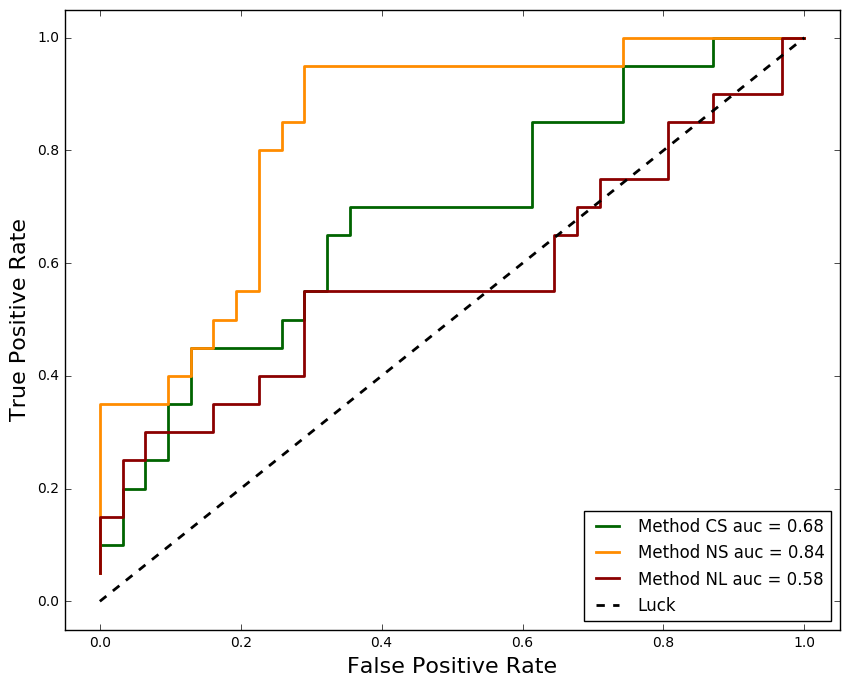

In [28]:
# plot for binary
# 'combinedcellclusters_maxD10_k95',
methods = ['colorobjectclusters','cellclusters_maxD10_k95',
         'nucFeats']
lg_txt = ['CS','NS', 'NL']
colors = ['darkgreen','darkorange', 'darkred', 'darkblue','blue']
plt.figure()
for method, color,lg in zip(methods, colors, lg_txt):
    key = (method+'_test_bin')
    plt.plot(fpr_dict[key], tpr_dict[key], lw=lw, color=color,
             label='Method %s auc = %0.2f' % (lg, auc_dict[key]))

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',size=16)
plt.ylabel('True Positive Rate', size = 16)
#plt.title('Binary classification results')
plt.legend(loc="lower right")
plt.show()

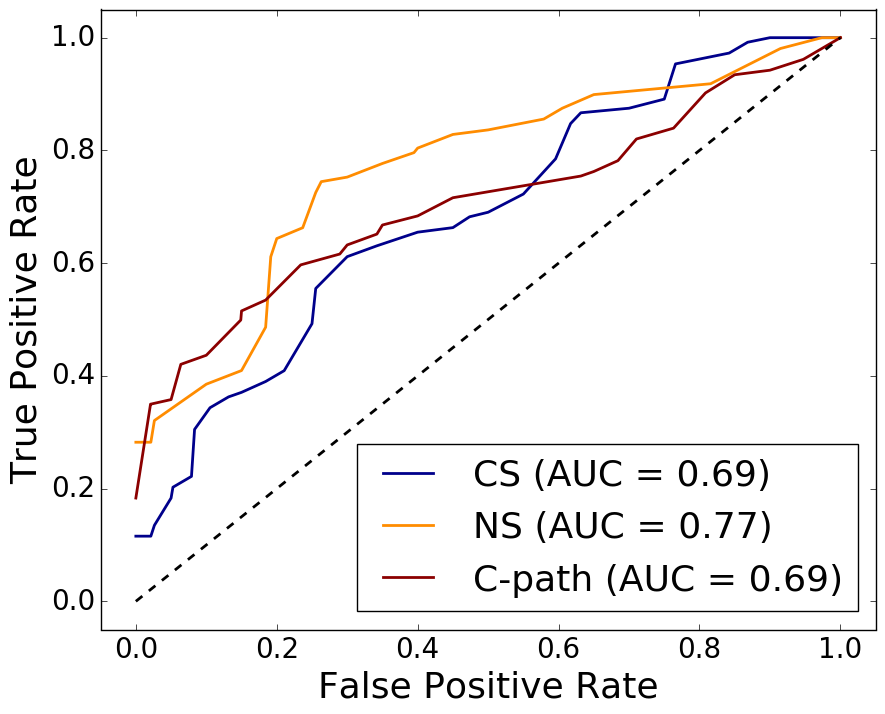

In [52]:
# plot for binary
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
methods = ['colorobjectclusters','cellclusters_maxD10_k95',
         'nucFeats']
lg_txt = ['CS','NS', 'C-path']
colors = ['darkblue','darkorange', 'darkred', 'darkblue','blue']
lw = 2
plt.figure()
for method, color,lg in zip(methods, colors, lg_txt):
    key = (method+'_macro_test_4way')
    plt.plot(fpr_dict[key], tpr_dict[key], lw=lw, color=color,
             label='%s (AUC = %0.2f)' % (lg, auc_dict[key]))

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
font_size = 26
plt.xlabel('False Positive Rate',size= font_size)
plt.ylabel('True Positive Rate', size = font_size)
#plt.title('Binary classification results')
plt.legend(loc="lower right",prop={'size':font_size})
plt.show()

In [ ]:
# plot for binary
methods = ['colorobjectclusters','cellclusters_maxD10_k95',
        'combinedcellclusters_maxD10_k95', 'nucFeats']
lg_txt = ['Col. Spatial','Nuc. Spatial', 
          'Col.+Nuc. Spatial','Nuc. Local']
colors = ['lightgreen', 'indigo', 'darkorange','turquoise'
          ,'blue']
lw = 2
plt.figure()
for method, color,lg in zip(methods, colors, lg_txt):
    key = (method+'_micro_test_4way')
    plt.plot(fpr_dict[key], tpr_dict[key], lw=lw, color=color,
             label='Method %s auc = %0.2f' % (lg, auc_dict[key]))

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',size=16)
plt.ylabel('True Positive Rate', size = 16)
#plt.title('Binary classification results')
plt.legend(loc="lower right")
plt.show()